In [1]:
import os
import sys
import math
from copy import deepcopy

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
os.environ["CUDA_VISIBLE_DEVICES"]="7"
if torch.cuda.is_available():
    device = torch.cuda.device("cuda:7")
    use_cuda = True

In [2]:
sys.path.insert(0, 'utils/')
from MyUtils import *
from MyDatasets import *

In [3]:
class Classifier(nn.Module):
    def __init__(self, in_size):
        super(Classifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x).view(-1)

In [4]:
class Classifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [ ]:
dataset_c_train = TwoCircleDataset(1, 1.5, 5000, 100, train=True)
dataset_c_test = TwoCircleDataset(1, 1.5, 5000, 100, train=False)
dataset_c_validation = TwoCircleDataset(1, 1.5, 5000, 100, train=False)
dataloader_c_train = DataLoader(dataset_c_train, batch_size=128, shuffle=True)
dataloader_c_test = DataLoader(dataset_c_test, batch_size=128, shuffle=True)
dataloader_c_validation = DataLoader(dataset_c_validation, batch_size=128, shuffle=True)

dataset_g_train = TwoGaussiansDataset(0., 0.5, 5000, 100, train=True)
dataset_g_test = TwoGaussiansDataset(0., 0.5, 5000, 100, train=False)
dataset_g_validation = TwoGaussiansDataset(0., 0.5, 5000, 100, train=False)
dataloader_g_train = DataLoader(dataset_g_train, batch_size=128, shuffle=True)
dataloader_g_test = DataLoader(dataset_g_test, batch_size=128, shuffle=True)
dataloader_g_validation = DataLoader(dataset_g_validation, batch_size=128, shuffle=True)

In [5]:
def grid_search(lr_split, rl_split, max_missclass_error, net_class, *args, **kwargs):
    lr_best = 0
    rl_best = 0
    err_best = 10e10
    for lr in lr_split:
        for rl in rl_split:
            net = net_class(*args)
            if use_cuda:
                net = net.cuda()
            res = train_(network=net, loss_func=kwargs['loss_func'],
                         learning_rate=lr, reinit_optim=kwargs['reinit_optim'],
                         train_strategy=kwargs['train_strategy'], test_strategy=kwargs['test_strategy'],
                         reg_lambda=rl,
                         epochs=kwargs['epochs'],
                         dataloader_train=kwargs['dataloader_train'], dataloader_test=kwargs['dataloader_test'],
                         plot_graphs=False, verbose=True,
                         epoch_hook=kwargs['epoch_hook']() if 'epoch_hook' in kwargs else None
                        )
            
            missclass_err_test = res[3][-1]
            missclass_err_train = res[1][-1]
            
            if missclass_err_test < err_best and missclass_err_train <= max_missclass_error:
                err_best = missclass_err_test
                lr_best = lr
                rl_best = rl
    return lr_best, rl_best, err_best

## Two N-dim concentric spheres

### Without Exp Neuron

In [ ]:
grid_search(np.logspace(-4, 1, 10), [None], 0, Classifier, 100, 
            loss_func=loss_func,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test,
#             epoch_hook=convergence_analysys_hook
           )

In [ ]:
net_c = Classifier(100)
if use_cuda:
    net_c = net_c.cuda()

train_(network=net_c, loss_func=loss_func,
       learning_rate=0.0021, reinit_optim=1500,
       train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
       reg_lambda=None,
       epochs=300,
       dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_validation,
       )

### With Exp Neuron

In [ ]:
grid_search(np.logspace(-3, 1, 8), np.logspace(-4, 1, 10), 0, Classifier_WITH_EXP, 100, 
            loss_func=loss_func_EXP,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test,
#             epoch_hook=convergence_analysys_hook
           )

In [ ]:
net_c_e = Classifier_WITH_EXP(100)
if use_cuda:
    net_c_e = net_c_e.cuda()
net_c_e.explinear.init_weigth(0, 0.001)

train_EXP(network=net_c_e, loss_func=loss_func_EXP,
          learning_rate=0.0517, reinit_optim=400,
          train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
          reg_lambda=2.78,
          epochs=100,
          dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_validation
         )

## Two Gaussians

### Without Exp Neuron

In [ ]:
grid_search(np.logspace(-4, 1, 10), [None], 0, Classifier, 100, 
            loss_func=loss_func,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test,
#             epoch_hook=convergence_analysys_hook
           )

In [ ]:
net_g = Classifier(100)
if use_cuda:
    net_g = net_g.cuda()

train_(network=net_g, loss_func=loss_func,
       learning_rate=0.0001, reinit_optim=1000,
       train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
       reg_lambda=None,
       epochs=200,
       dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_validation,
       )

### With Exp Neuron

In [ ]:
grid_search(np.logspace(-3, 1, 5), np.logspace(-3, 1, 5), 0, Classifier_WITH_EXP, 100, 
            loss_func=loss_func_EXP,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test,
#             epoch_hook=convergence_analysys_hook
           )

In [ ]:
net_g_e = Classifier_WITH_EXP(100)
if use_cuda:
    net_g_e = net_g_e.cuda()

    
train_EXP(network=net_g_e, loss_func=loss_func_EXP,
          learning_rate=0.001, reinit_optim=1000,
          train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
          reg_lambda=0.001,
          epochs=600,
          dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_validation
         )

In [6]:
def plot_dataset(dataset, classes = None):
    if classes is None:
        classes = get_pure(dataset.classes)
    colors = np.where(classes <= 0, 'k', 'b')
    plt.figure(figsize=(5,5))
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.scatter(get_pure(dataset.dots[:, 0]), get_pure(dataset.dots[:, 1]), linewidth=0, c=colors)

In [ ]:
plot_dataset(dataset_c_train)

In [ ]:
plot_dataset(dataset_c_test)

In [ ]:
plot_dataset(dataset_c_test, get_pure(net_c(dataset_c_test.dots)))

In [ ]:
plot_dataset(dataset_c_test, get_pure(net_c_e(dataset_c_test.dots)))

# MNIST

In [7]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform, class_nums=set([1, 7]))
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform, class_nums=set([1, 7]))


dataloader_m_train = DataLoader(dataset_m_train, batch_size=32, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=32, shuffle=True)

0.00B [00:00, ?B/s]

9.92MB [00:05, 1.71MB/s]                            
32.8kB [00:00, 599kB/s]
 42%|████▏     | 696k/1.65M [00:00<00:00, 6.89MB/s]

1.65MB [00:00, 9.89MB/s]                           
8.19kB [00:00, 651kB/s]


Processing...
Done!


In [8]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x).view(-1)

In [9]:
class ConvClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(ConvClassifier_WITH_EXP, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.explinear = ExpLinear(in_size)
    
    def forward(self, x):
        y = self.explinear(x.view(x.shape[0], -1)).view(-1)
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        return self.linear_layers(x).view(-1) + y
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [16]:
class ClassifierAug(nn.Module):
    def __init__(self, in_size):
        super(ClassifierAug, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 2, in_size // 4),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x).view(-1)
    
    def get_alpha(self):
        return 0

In [ ]:
grid_search(np.logspace(-4, 1, 10), [None], 0, ConvClassifier, 
            loss_func=loss_func,
            reinit_optim=1000,
            train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
            epochs=22,
            dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
            epoch_hook=convergence_analysys_hook
           )

In [11]:
net_m = ConvClassifier()
if use_cuda:
    net_m = net_m.cuda()

Epoch 3... Empirical Loss/Misclassification Rate (Train): 0.114/13.000	 Empirical Loss/Misclassification Rate (Test): 0.124/2.0000

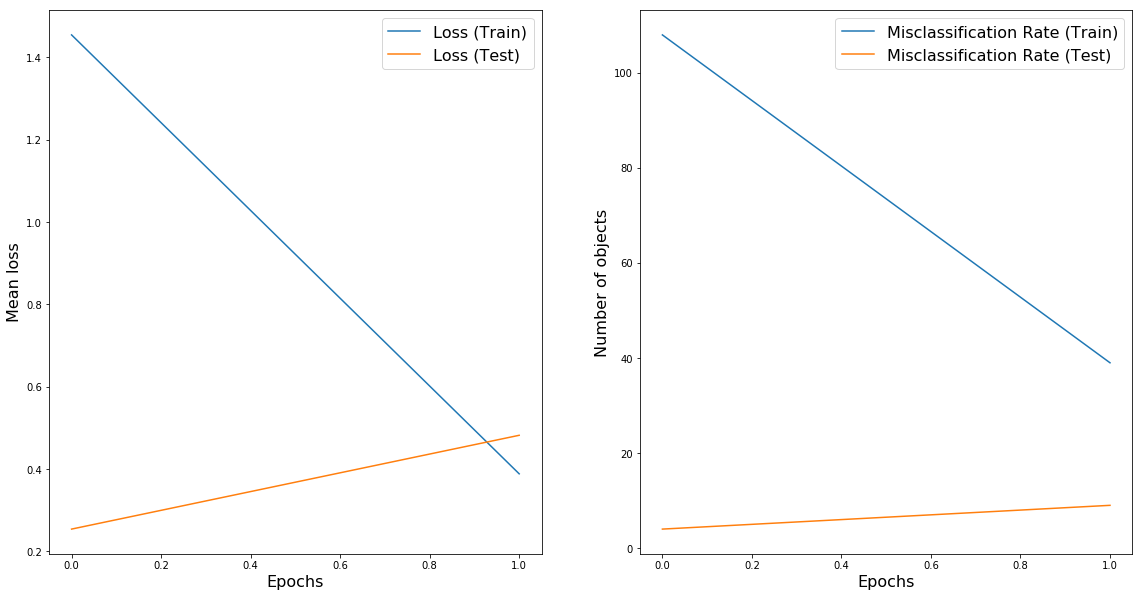

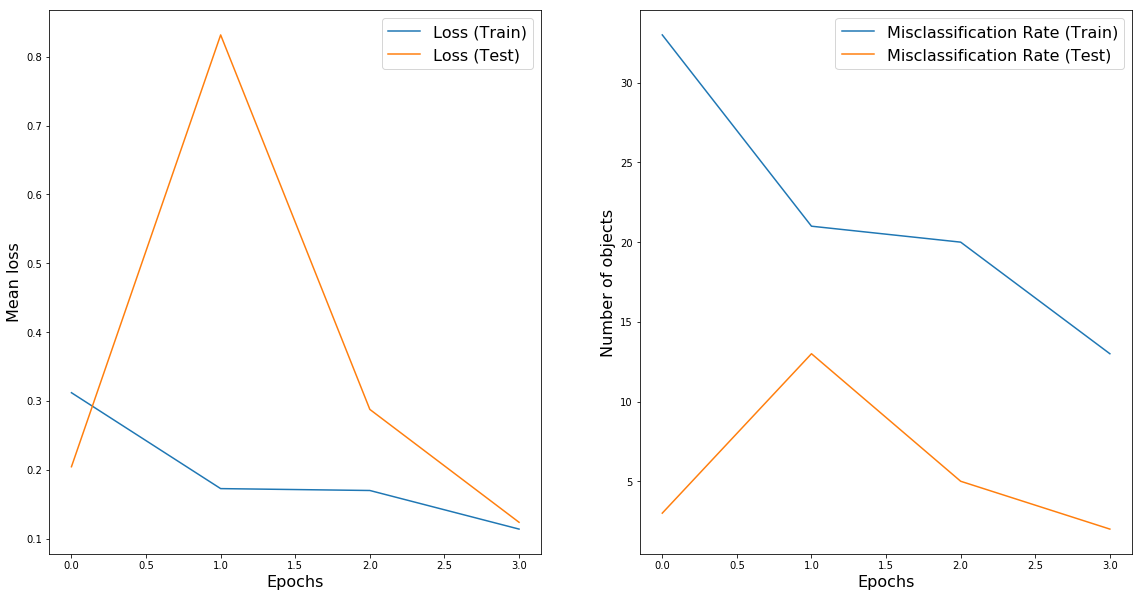

In [12]:
train_(network=net_m, loss_func=loss_func,
       learning_rate=0.0001, reinit_optim=100,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=2,
       dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
       )
train_(network=net_m, loss_func=loss_func,
       learning_rate=0.0001, reinit_optim=100,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=20,
       dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
#        epoch_hook=convergence_analysys_hook()
       )

In [ ]:
grid_search(np.logspace(-3, 1, 5), np.logspace(-3, 1, 5), 0, ConvClassifier_WITH_EXP, 28 * 28, 
            loss_func=loss_func_EXP,
            reinit_optim=1000,
            train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
            epochs=22,
            dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
            epoch_hook=convergence_analysys_hook
           )

In [13]:
net_m_e = ConvClassifier_WITH_EXP(28 * 28)
if use_cuda:
    net_m_e = net_m_e.cuda()

Epoch 2... Empirical Loss/Misclassification Rate (Train): 0.312/34.000	 Empirical Loss/Misclassification Rate (Test): 1.056/19.0000

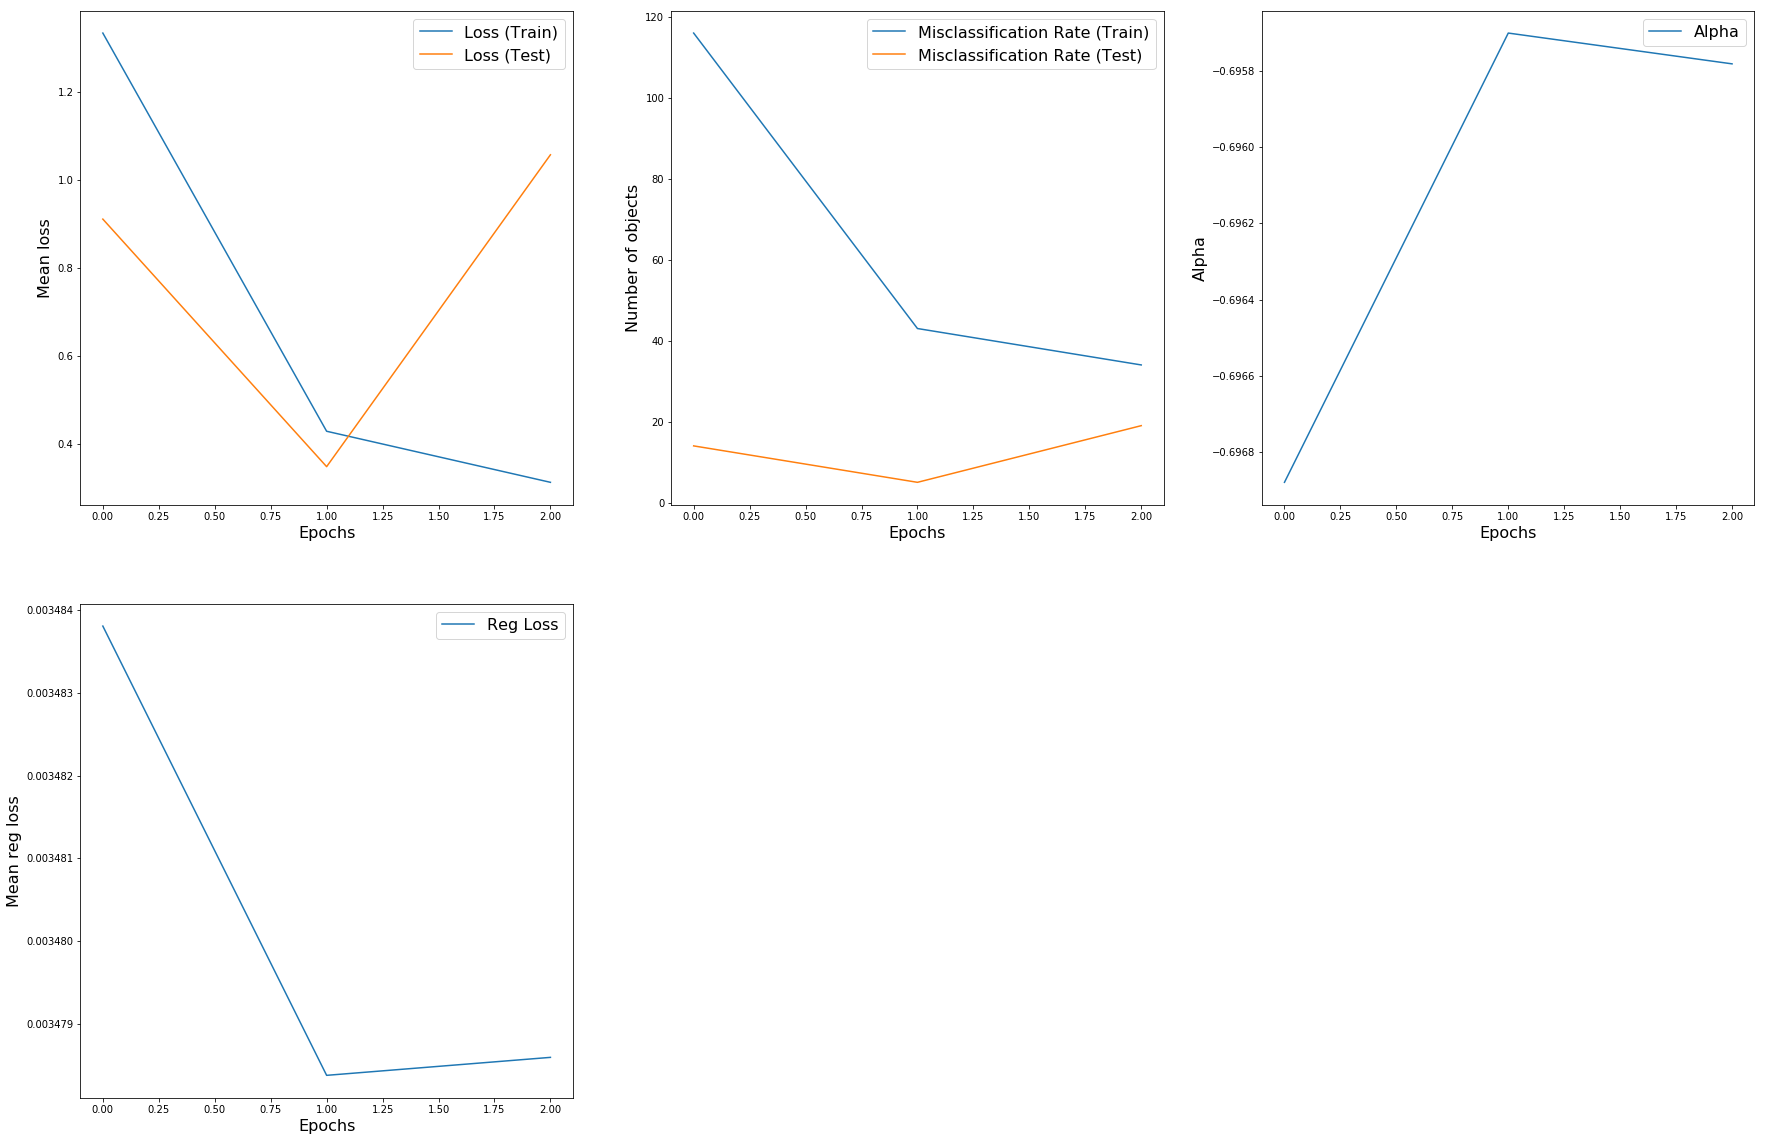

In [15]:
train_EXP(network=net_m_e, loss_func=loss_func_EXP,
          learning_rate=0.001, reinit_optim=100,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.005,
          epochs=35,
          dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
#           epoch_hook=convergence_analysys_hook()
         )

In [17]:
net_m_fc_a = ClassifierAug(28 * 28)
if use_cuda:
    net_m_fc_a = net_m_fc_a.cuda()

Epoch 1... Empirical Loss/Misclassification Rate (Train): 0.684/59.000	 Empirical Loss/Misclassification Rate (Test): 1.074/18.0000

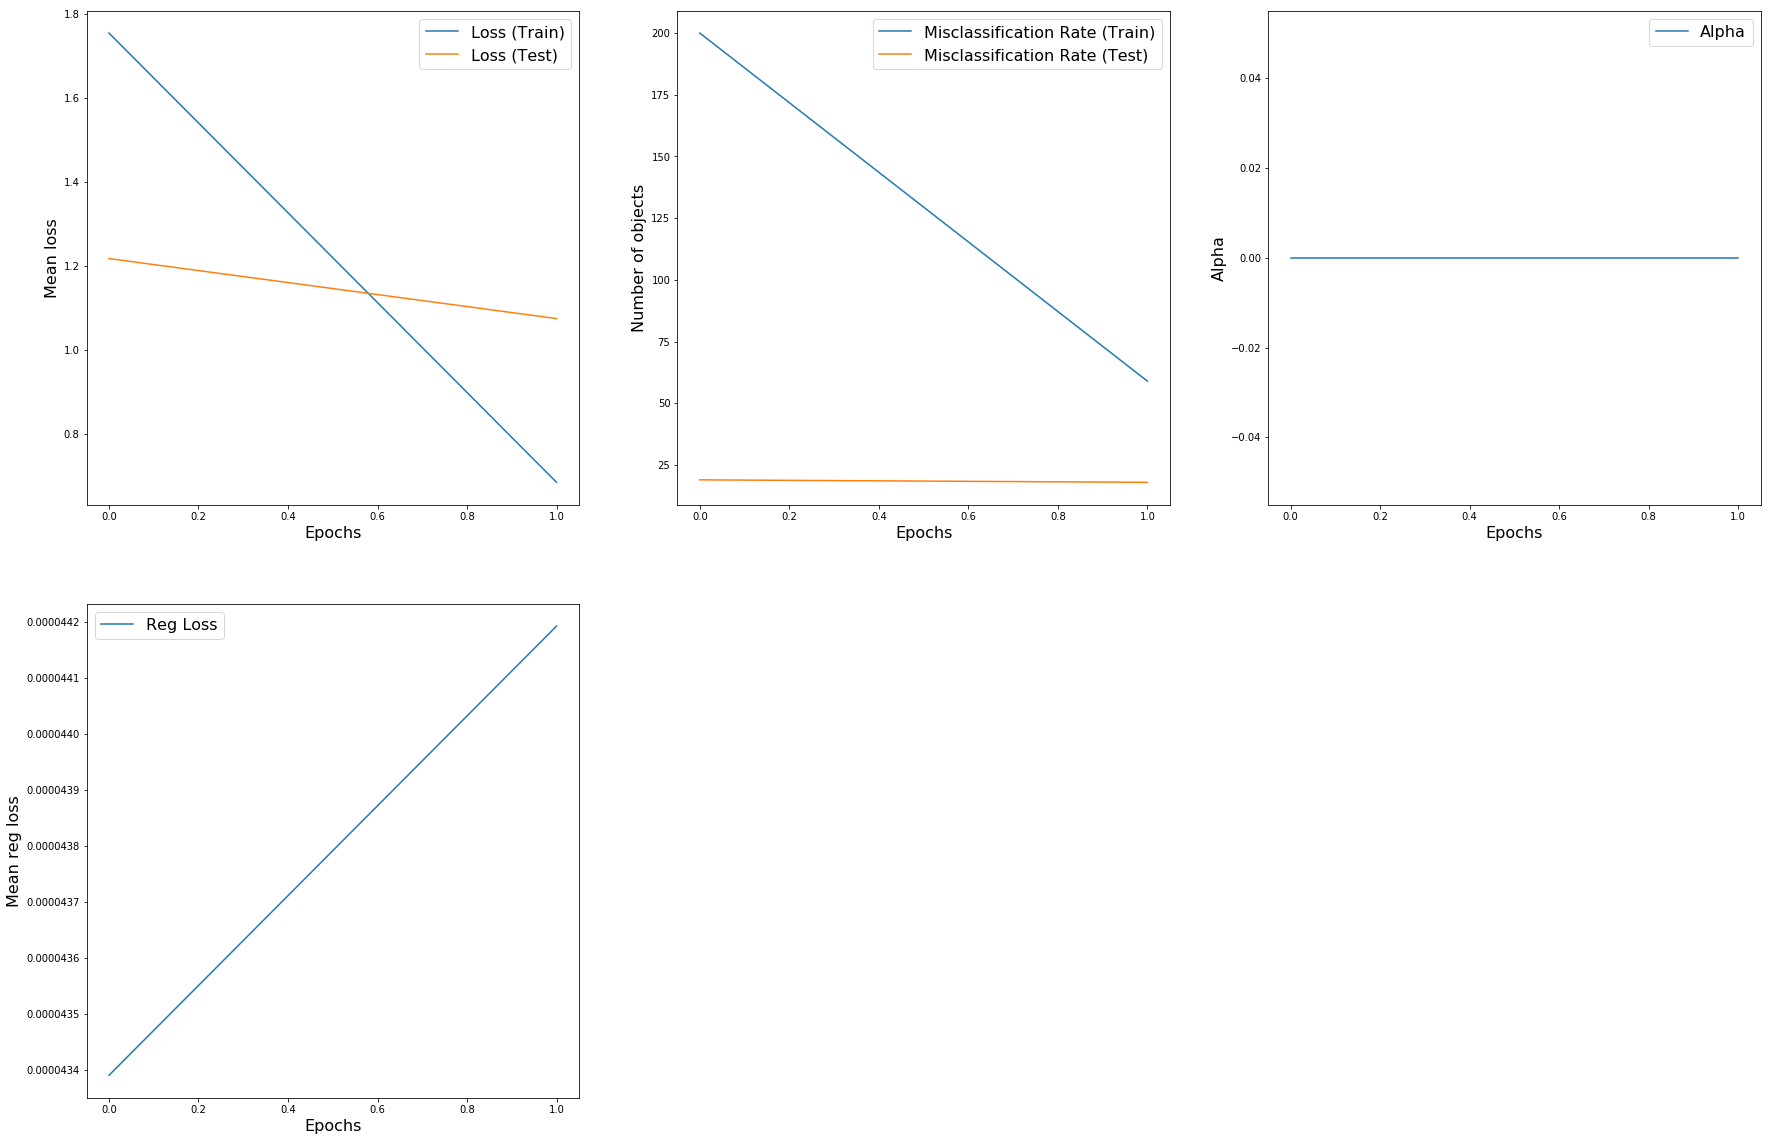

In [18]:
train_EXP(network=net_m_fc_a, loss_func=loss_func_AUG,
          learning_rate=0.001, reinit_optim=100,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.00005,
          epochs=30,
          dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test
         )

# CIFAR

In [20]:
dataset_CIF_train = CIFARDataset(train=True)
dataset_CIF_test = CIFARDataset(train=False)
dataset_CIF_validation = CIFARDataset(train=False)
dataloader_CIF_train = DataLoader(dataset_CIF_train, batch_size=128, shuffle=True)
dataloader_CIF_test = DataLoader(dataset_CIF_test, batch_size=128, shuffle=True)

In [ ]:
grid_search(np.logspace(-4, 1, 10), [None], 0, Classifier, 32 * 32 * 3,
            loss_func=loss_func,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
            epoch_hook=convergence_analysys_hook
           )

In [21]:
net_CIF_fc = Classifier(32 * 32 * 3)
if use_cuda:
    net_CIF_fc = net_CIF_fc.cuda()

Epoch 20... Empirical Loss/Misclassification Rate (Train): 16.566/0.000	 Empirical Loss/Misclassification Rate (Test): 1880.426/324.000000

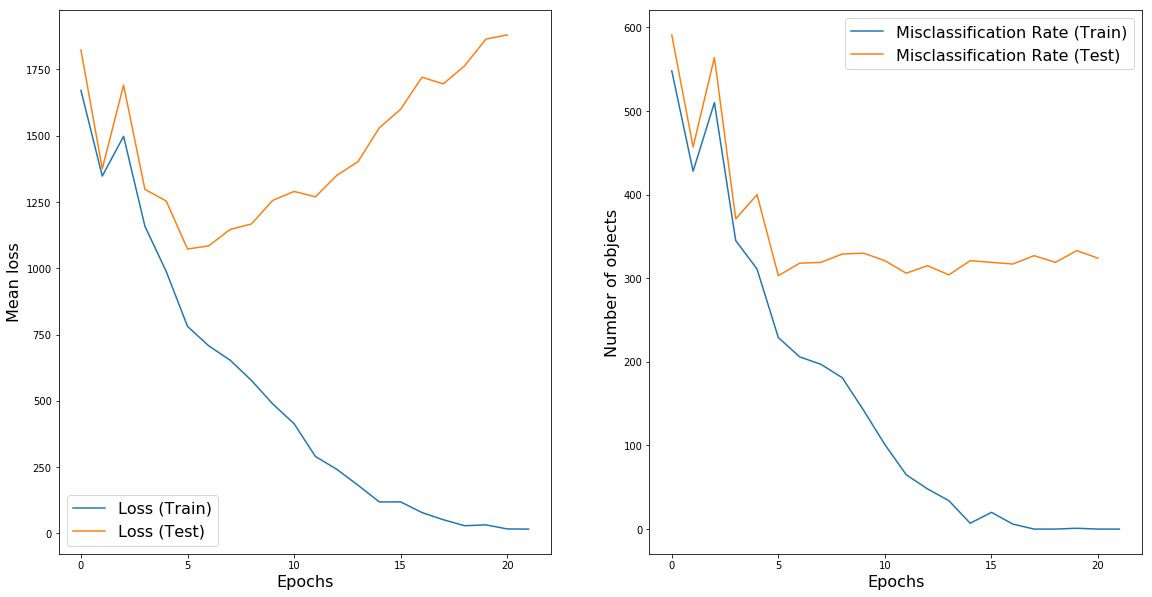

In [22]:
train_(network=net_CIF_fc, loss_func=loss_func,
       learning_rate=0.0004, reinit_optim=1000,
       train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
       reg_lambda=None,
       epochs=200,
       dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
#        epoch_hook=convergence_analysys_hook()
       )

In [ ]:
net_CIF_fc_a = ClassifierAug(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_a = net_CIF_fc_a.cuda()

In [ ]:
train_EXP(network=net_CIF_fc_a, loss_func=loss_func_AUG,
          learning_rate=0.0001, reinit_optim=2000,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.0005,
          epochs=300,
          dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
          epoch_hook=convergence_analysys_hook
         )

In [ ]:
grid_search(np.logspace(-3, 1, 5), np.logspace(-3, 1, 5), 0, Classifier_WITH_EXP, 3072, 
            loss_func=loss_func_EXP,
            reinit_optim=1000,
            train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
            epochs=200,
            dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
            epoch_hook=convergence_analysys_hook
           )

In [ ]:
net_CIF_fc_e = Classifier_WITH_EXP(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_e = net_CIF_fc_e.cuda()

In [ ]:
train_EXP(network=net_CIF_fc_e, loss_func=loss_func_EXP,
          learning_rate=0.0001, reinit_optim=2000,
          train_strategy=train_strategy_NO_STOCH, test_strategy=test_strategy_NO_STOCH,
          reg_lambda=0.0005,
          epochs=300,
          dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
#           epoch_hook=convergence_analysys_hook()
         )

# Small networks

In [ ]:
class Classifier_SMALL(nn.Module):
    def __init__(self, in_size):
        super(Classifier_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            nn.Tanh(),
            nn.Linear(in_size // 512, in_size // 1024),
            nn.Tanh(),
            nn.Linear(in_size // 1024, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [ ]:
class Classifier_WITH_EXP_SMALL(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            nn.Sigmoid(),
            nn.Linear(in_size // 512, in_size // 1024),
            nn.Sigmoid(),
            nn.Linear(in_size // 1024, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [ ]:
class ClassifierAug_SMALL(nn.Module):
    def __init__(self, in_size):
        super(ClassifierAug_SMALL, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 512),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 512, in_size // 1024),
            AugActivation(nn.Sigmoid()),
            nn.Linear(in_size // 1024, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [ ]:
net_CIF_fc_s = Classifier_SMALL(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_s = net_CIF_fc_s.cuda()

In [ ]:
train_(network=net_CIF_fc_s, loss_func=loss_func,
       learning_rate=0.00001, reinit_optim=10000,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=2000,
       dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
       epoch_hook=convergence_analysys_hook()
       )

In [ ]:
net_CIF_fc_s_e = Classifier_WITH_EXP_SMALL(32 * 32 * 3)
if use_cuda:
    net_CIF_fc_s_e = net_CIF_fc_s_e.cuda()

In [ ]:
train_EXP(network=net_CIF_fc_s_e, loss_func=loss_func_EXP,
          learning_rate=0.00005, reinit_optim=8000,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.5,
          epochs=1000,
          dataloader_train=dataloader_CIF_train, dataloader_test=dataloader_CIF_test,
          epoch_hook=convergence_analysys_hook()
         )

# Analysys stuff and hooks

In [ ]:
def explinear_analysys_hook(**kwargs):
    if 'cnt' not in explinear_analysys_hook.__dict__:
        explinear_analysys_hook.cnt = 0
        explinear_analysys_hook.prev_explinear_params = deepcopy(dict(kwargs['network'].explinear.named_parameters()))
        dict(kwargs['network'].explinear.named_parameters())['linear.0.weight'].register_hook(print)
    else:
        print('\nexplinear_params: ')
        for name, param in kwargs['network'].explinear.named_parameters():
            print(get_pure(deepcopy(param)))
            
        print('explinear_params_delta: ')
        for name, param in kwargs['network'].explinear.named_parameters():
            print(get_pure((deepcopy(param) - explinear_analysys_hook.prev_explinear_params[name]).norm(2)))
        explinear_analysys_hook.prev_explinear_params = deepcopy(dict(kwargs['network'].explinear.named_parameters()))

        bch = next(iter(kwargs['dataloader_test']))[0]
        print('\nbatch_max (linear / explinear): ')
        print(max(get_pure(kwargs['network'].linear(bch))))    
        print(max(get_pure(kwargs['network'].explinear(bch))))

In [ ]:
def add_noise(network):
    for _, param in network.explinear.named_parameters():
        bias = torch.zeros_like(param).cuda()
        if len(param.shape) == 1:
            bias = torch.distributions.normal.Normal(0, 0.06).sample_n(param.shape[0]).cuda()
        else:
            bias = torch.distributions.normal.Normal(0, 0.06).sample_n(param.shape[0] * param.shape[1]).cuda()
        param.data += bias

In [ ]:
def calc_loss(network, dataloader):
    bch, lbls = next(iter(dataloader))
    bch_norm = bch[0].norm(2)
    loss = nn.HingeEmbeddingLoss()(network(bch), lbls)**3
    print('Batch Norm: ', bch_norm)
    print('Loss: ', loss)
    return bch_norm, loss

In [ ]:
def plot_img(im):
    rr = np.zeros([3, 32, 32])
    rr[0,:,:] = im[:1024].reshape(32, 32)
    rr[1,:,:] = im[1024:2048].reshape(32, 32)
    rr[2,:,:] = im[2048:].reshape(32, 32)
    rr = rr.transpose(1, 2, 0)
    plt.imshow(rr)

In [ ]:
class convergence_analysys_hook():
    def __init__(self):
        self.is_conv = False
        
    def __call__(self, **kwargs):
        if kwargs['misscl_rate_train'][-1] == 0 and not self.is_conv:
            self.is_conv = True
            print('\nConv epoch: ', kwargs['epoch'])
            print('Learning rate: ', kwargs['learning_rate'])
            try:
                print('Reg Lambda: ', kwargs['reg_lambda'])
            except KeyError:
                pass
            raise KeyboardInterrupt